# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'comp411/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


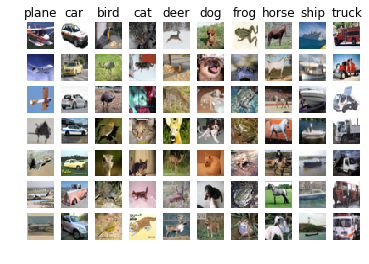

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


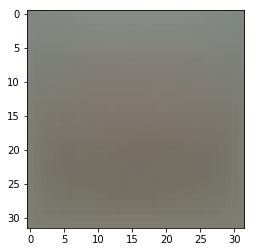

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `comp411/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from comp411.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.143243


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from comp411.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -68.441313 analytic: -68.441313, relative error: 3.633520e-12
numerical: 9.306844 analytic: 9.306844, relative error: 4.454499e-11
numerical: 0.630159 analytic: 0.630159, relative error: 6.313035e-10
numerical: 13.664468 analytic: 13.664468, relative error: 2.012938e-11
numerical: -21.259809 analytic: -21.259809, relative error: 4.089083e-12
numerical: -1.742862 analytic: -1.742862, relative error: 1.260385e-10
numerical: 32.852579 analytic: 32.852579, relative error: 1.369423e-11
numerical: 1.433197 analytic: 1.433197, relative error: 2.489707e-10
numerical: 15.912103 analytic: 15.912103, relative error: 1.790970e-11
numerical: 1.027505 analytic: 1.027505, relative error: 2.748971e-10
numerical: -7.598613 analytic: -7.598613, relative error: 1.082197e-11
numerical: -11.833291 analytic: -11.833291, relative error: 1.233647e-12
numerical: 22.529341 analytic: 22.529341, relative error: 2.820019e-12
numerical: 26.450027 analytic: 26.450027, relative error: 7.454042e-12
numerica

## Modified Huber Classifier

Your code for this section will all be written inside `comp411/classifiers/linear_svm.py`. 

The Modified Huber Loss implementaiton should be similar to SVM Hinge Loss.

In [10]:
# Now implement and Evaluate the naive implementation of the huber loss:
from comp411.classifiers.linear_svm import huber_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = huber_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 10.835923


In [93]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = huber_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from comp411.gradient_check import grad_check_sparse
f = lambda w: huber_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = huber_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: huber_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -4.788048 analytic: -4.788048, relative error: 3.088606e-11
numerical: -5.107471 analytic: -5.107471, relative error: 8.585600e-12
numerical: -7.277267 analytic: -7.277267, relative error: 4.316887e-11
numerical: -45.679672 analytic: -45.679672, relative error: 3.111913e-12
numerical: 94.511690 analytic: 94.511690, relative error: 1.048616e-12
numerical: 87.877195 analytic: 87.877195, relative error: 1.390486e-12
numerical: 76.905217 analytic: 76.905217, relative error: 3.866883e-12
numerical: 68.927198 analytic: 68.927198, relative error: 8.314915e-12
numerical: 78.162280 analytic: 78.162281, relative error: 2.017834e-09
numerical: 18.846640 analytic: 18.846640, relative error: 8.774034e-12
numerical: 50.224884 analytic: 50.224884, relative error: 1.013436e-12
numerical: -24.721100 analytic: -24.721100, relative error: 6.649617e-12
numerical: -4.372643 analytic: -4.372643, relative error: 1.574436e-11
numerical: 6.058844 analytic: 6.058844, relative error: 1.888472e-11
nume

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [65]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.069962e+00 computed in 0.185187s
Vectorized loss: 9.069962e+00 computed in 0.008895s
difference: -0.000000


In [66]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.431105s
Vectorized loss and gradient: computed in 0.004362s
difference: 0.000000


In [174]:
# Next implement the function huber_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = huber_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.linear_svm import huber_loss_vectorized
tic = time.time()
loss_vectorized, _ = huber_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 1.083592e+01 computed in 0.320359s
Vectorized loss: 1.083592e+01 computed in 0.006664s
difference: 0.000000


In [173]:
# Complete the implementation of huber_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = huber_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = huber_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.415300s
Vectorized loss and gradient: computed in 0.005323s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [172]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from comp411.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()

loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 783.280994
iteration 100 / 1500: loss 285.555437
iteration 200 / 1500: loss 106.776040
iteration 300 / 1500: loss 42.818204
iteration 400 / 1500: loss 18.836844
iteration 500 / 1500: loss 10.242701
iteration 600 / 1500: loss 7.164543
iteration 700 / 1500: loss 5.939695
iteration 800 / 1500: loss 5.439160
iteration 900 / 1500: loss 5.636448
iteration 1000 / 1500: loss 5.718168
iteration 1100 / 1500: loss 4.686508
iteration 1200 / 1500: loss 5.349286
iteration 1300 / 1500: loss 5.646877
iteration 1400 / 1500: loss 5.520556
That took 8.960620s


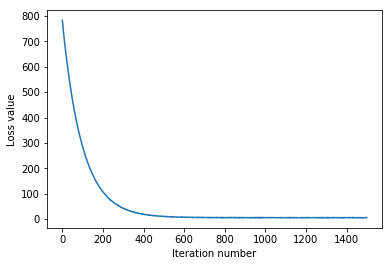

In [175]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [176]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.367816
validation accuracy: 0.369000


### Stochastic Gradient Descent
We also have vectorized and efficient expressions for the huber loss, the gradient and our gradient matches the numerical gradient. Thus, we are also ready to do SGD to minimize the huber loss.

In [177]:
from comp411.classifiers import LinearHuber
huber = LinearHuber()
tic = time.time()

loss_hist = huber.train(X_train, y_train, learning_rate=3e-7, reg=0,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 76.476806
iteration 100 / 1500: loss 18.395046
iteration 200 / 1500: loss 15.476439
iteration 300 / 1500: loss 12.238282
iteration 400 / 1500: loss 12.412191
iteration 500 / 1500: loss 12.612212
iteration 600 / 1500: loss 9.651109
iteration 700 / 1500: loss 11.123531
iteration 800 / 1500: loss 10.305023
iteration 900 / 1500: loss 11.966325
iteration 1000 / 1500: loss 12.088233
iteration 1100 / 1500: loss 10.765306
iteration 1200 / 1500: loss 9.391889
iteration 1300 / 1500: loss 8.908081
iteration 1400 / 1500: loss 10.675328
That took 6.783256s


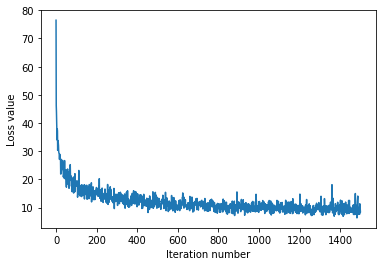

In [178]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [181]:
# Lets evaluate the performance on both the
# training and validation set
y_train_pred = huber.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = huber.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

## at minumim, you should see accuracy results around 0.25

training accuracy: 0.341224
validation accuracy: 0.333000


In [253]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate) and loss type (svm hinge or modified huber). You should experiment
# with different ranges for the learning rates and regularization strengths and cases
# for the loss type. If you are careful you should be able to
# get a classification accuracy of about 0.39 or higher on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug however you may want to add 
# safety margins for possible overflow/underflow causing operations in your .py implementations.

#Note: you may want to observe the behavioral differences between standard
#      svm hinge loss and modified huber loss

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength, loss_type) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best = None #  The LinearSVM or LinearHuber object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        
# Write code that chooses the best hyperparameters by tuning on the validation 
# set. For each combination of hyperparameters, train a linear SVM and a linear
# Huber on the training set, compute their accuracy on the training and 
# validation sets, and store these numbers in the results dictionary. In 
# addition, store the best validation accuracy in best_val and the LinearSVM 
# or LinearHuber object that achieves this, accuracy in best.    
#                                
#                                                                              
# Hint: You should use a small value for num_iters as you develop your         
# validation code so that the SVMs don't take much time to train; once you are 
# confident that your validation code works, you should rerun the validation   
# code with a larger value for num_iters.                                      
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
# While using the plot below, best paras are found.
learning_rates = [1e-7, 2e-7, 5e-5]
regularization_strengths = [2.5e4, 3.5e4, 5e4]
loss_types = ["SVM", "Huber"]
best_paras = None # lr, reg, lt

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

hyperparameters = [(lr,reg,lt) for lr in learning_rates for reg in regularization_strengths for lt in loss_types]

for lr, reg, lt in hyperparameters:
    if lt == "SVM":
        model = LinearSVM()
    else:
        model = LinearHuber()
    
    model.train(X_train, y_train, lr, reg,num_iters=1000)
    train_accuracy = np.mean(model.predict(X_train) == y_train) 
    val_accuracy = np.mean(model.predict(X_val) == y_val)
    
    results[(lr,reg,lt)] = (train_accuracy,val_accuracy)

    if best_val <= val_accuracy:
        best = model
        best_val = val_accuracy
        best_paras = (lr, reg, lt)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg, lt in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, lt)] 
    print('lr %e reg %e type %s train accuracy: %f val accuracy: %f' % (
                lr, reg, lt, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f with lr: %e, reg: %e, model: %s'  
% (best_val,best_paras[0],best_paras[1],best_paras[2]))

lr 1.000000e-07 reg 2.500000e+04 type Huber train accuracy: 0.375592 val accuracy: 0.364000
lr 1.000000e-07 reg 2.500000e+04 type SVM train accuracy: 0.368408 val accuracy: 0.366000
lr 1.000000e-07 reg 3.500000e+04 type Huber train accuracy: 0.367286 val accuracy: 0.369000
lr 1.000000e-07 reg 3.500000e+04 type SVM train accuracy: 0.361592 val accuracy: 0.378000
lr 1.000000e-07 reg 5.000000e+04 type Huber train accuracy: 0.343265 val accuracy: 0.336000
lr 1.000000e-07 reg 5.000000e+04 type SVM train accuracy: 0.361163 val accuracy: 0.365000
lr 2.000000e-07 reg 2.500000e+04 type Huber train accuracy: 0.270184 val accuracy: 0.291000
lr 2.000000e-07 reg 2.500000e+04 type SVM train accuracy: 0.360857 val accuracy: 0.378000
lr 2.000000e-07 reg 3.500000e+04 type Huber train accuracy: 0.291510 val accuracy: 0.294000
lr 2.000000e-07 reg 3.500000e+04 type SVM train accuracy: 0.349367 val accuracy: 0.362000
lr 2.000000e-07 reg 5.000000e+04 type Huber train accuracy: 0.291286 val accuracy: 0.30300

Text(0.5, 1.0, 'Huber-10 validation accuracy')

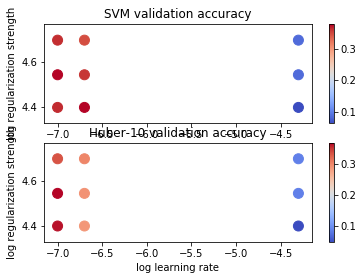

In [267]:
# Visualize the differences between model
import math

svm_results = {}
huber_results = {}
for paras in results:
    if (paras[2] == "SVM"):
        svm_results[paras[:2]] = results[paras] 
    else :
        huber_results[paras[:2]] = results[paras]


x_scatter = [math.log10(x[0]) for x in svm_results]
y_scatter = [math.log10(x[1]) for x in svm_results]

# plot training accuracy
marker_size = 100
colors = [svm_results[x][1] for x in svm_results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('SVM validation accuracy')


x_scatter = [math.log10(x[0]) for x in huber_results]
y_scatter = [math.log10(x[1]) for x in huber_results]

colors = [huber_results[x][1] for x in huber_results]
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Huber-10 validation accuracy')

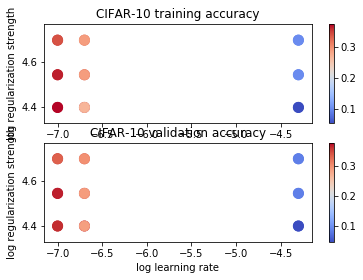

In [254]:
# Visualize the cross-validation results
import math

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [255]:
# Evaluate the best linear classifier on test set
y_test_pred = best.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear classifier on raw pixels final test set accuracy: %f' % test_accuracy)

linear classifier on raw pixels final test set accuracy: 0.352000


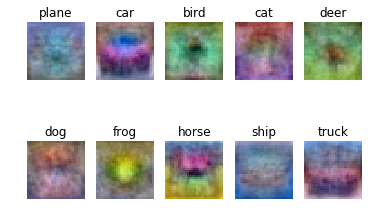

In [256]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized linear classifier weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ The weigth looks like the class presentations of their classes. The reason is that they are the inputs that gives the best solutions for their classes. For example, for car class, best solution would be an car resemblance input. 
